# Lab 1: Customer Churn Prediction using Neural Network



In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the Data Set
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn (1).csv")


In [13]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (7043, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

In [14]:
# Display first few rows
print("\nFirst few rows of the dataset:")
df.head()


First few rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
print("\nChurn Distribution:")
churn_dist = df['Churn'].value_counts(normalize=True)
print(churn_dist)



Churn Distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


## Task 2: Data Preprocessing and Class Imbalance Handling


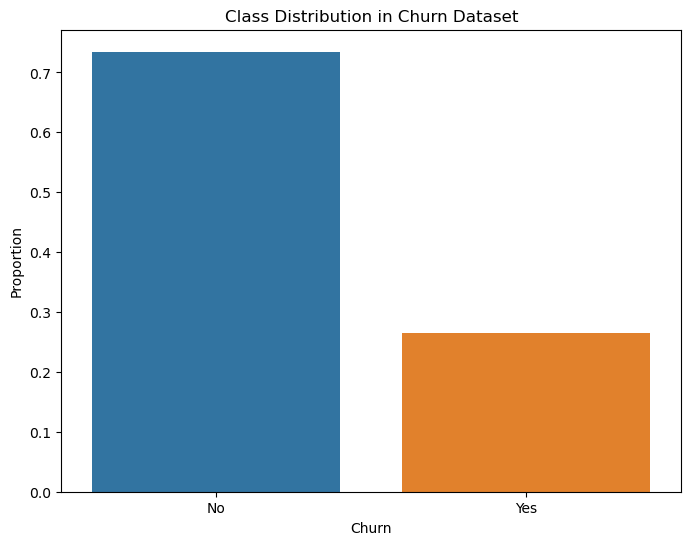

In [16]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_dist.index, y=churn_dist.values)
plt.title('Class Distribution in Churn Dataset')
plt.ylabel('Proportion')
plt.show()

### 2.1 Data Preprocessing


In [17]:
# Analyze special cases in services
service_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

print("Unique values in service columns:")
for col in service_columns:
    print(f"\n{col}:", df[col].unique())
    print("Value counts:")
    print(df[col].value_counts())


Unique values in service columns:

MultipleLines: ['No phone service' 'No' 'Yes']
Value counts:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

InternetService: ['DSL' 'Fiber optic' 'No']
Value counts:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity: ['No' 'Yes' 'No internet service']
Value counts:
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

OnlineBackup: ['Yes' 'No' 'No internet service']
Value counts:
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

DeviceProtection: ['No' 'Yes' 'No internet service']
Value counts:
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

TechSupport: ['No' 'Yes' 'No internet service']
Value 

In [18]:
# Function to handle special cases in service columns
def preprocess_service_columns(df):
    df_processed = df.copy()

    # Handle MultipleLines special case
    df_processed['MultipleLines'] = df_processed['MultipleLines'].replace({
        'No phone service': 'No',  # Treat 'No phone service' same as 'No'
    })

    # Handle Internet-dependent services
    internet_dependent_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                                 'TechSupport', 'StreamingTV', 'StreamingMovies']

    for column in internet_dependent_services:
        df_processed[column] = df_processed[column].replace({
            'No internet service': 'No'  # Treat 'No internet service' same as 'No'
        })

    # Create binary flags for service availability
    df_processed['HasPhoneService'] = (df_processed['PhoneService'] == 'Yes').astype(int)
    df_processed['HasInternetService'] = (df_processed['InternetService'] != 'No').astype(int)

    return df_processed


In [19]:
# Apply preprocessing
df_processed = preprocess_service_columns(df)


In [20]:

# Verify the changes
print("\nAfter preprocessing - Unique values:")
for col in service_columns:
    print(f"\n{col}:", df_processed[col].unique())


After preprocessing - Unique values:

MultipleLines: ['No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes']

OnlineBackup: ['Yes' 'No']

DeviceProtection: ['No' 'Yes']

TechSupport: ['No' 'Yes']

StreamingTV: ['No' 'Yes']

StreamingMovies: ['No' 'Yes']


In [21]:
# Create aggregate service features
df_processed['TotalServices'] = (
    (df_processed[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                  'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes')
    .sum(axis=1)
)

df_processed['InternetType'] = df_processed['InternetService'].map({
    'DSL': 1,
    'Fiber optic': 2,
    'No': 0
})

In [22]:
# Separate columns by encoding type
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                 'StreamingTV', 'StreamingMovies']

multi_value_columns = ['InternetService', 'Contract', 'PaymentMethod']

# Encode binary columns
for column in binary_columns:
    df_processed[column + '_encoded'] = (df_processed[column] == 'Yes').astype(int)

# Encode multi-value columns using one-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=multi_value_columns, prefix=multi_value_columns)


In [23]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']
encoded_features = [col for col in df_encoded.columns if col.endswith('_encoded') or
                   any(prefix in col for prefix in multi_value_columns)]

X = df_encoded[numerical_features + encoded_features].values
y = (df_encoded['Churn'] == 'Yes').astype(int).values

print("\nFinal features:")
for i, feature in enumerate(numerical_features + encoded_features):
    print(f"{i}: {feature}")


Final features:
0: tenure
1: MonthlyCharges
2: TotalCharges
3: TotalServices
4: HasInternetService
5: gender_encoded
6: Partner_encoded
7: Dependents_encoded
8: PhoneService_encoded
9: PaperlessBilling_encoded
10: OnlineSecurity_encoded
11: OnlineBackup_encoded
12: DeviceProtection_encoded
13: TechSupport_encoded
14: StreamingTV_encoded
15: StreamingMovies_encoded
16: InternetService_DSL
17: InternetService_Fiber optic
18: InternetService_No
19: Contract_Month-to-month
20: Contract_One year
21: Contract_Two year
22: PaymentMethod_Bank transfer (automatic)
23: PaymentMethod_Credit card (automatic)
24: PaymentMethod_Electronic check
25: PaymentMethod_Mailed check


In [24]:
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                      'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                      'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                      'PaperlessBilling', 'PaymentMethod']

encoders = {}
for column in categorical_columns:
    encoders[column] = LabelEncoder()
    df[column + '_encoded'] = encoders[column].fit_transform(df[column])

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

X = df[['tenure', 'MonthlyCharges', 'TotalCharges'] +
       [col + '_encoded' for col in categorical_columns]].values
y = LabelEncoder().fit_transform(df['Churn'])

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [26]:
#resampling strategy says that oversampling becomes concerning when the % is 50% or more
#undersampling becomes a concern when 80% data is undersampled

over=SMOTE(sampling_strategy=0.5)
under=RandomUnderSampler(sampling_strategy=0.8)

#creating a resampling pipeline
resampling=Pipeline([('over',over),('under',under)])

X_resampled,y_resampled=resampling.fit_resample(X,y)

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,train_size=0.8)

In [28]:
X_train_tensor=torch.FloatTensor(X_train)
y_train_tensor=torch.FloatTensor(y_train)
X_test_tensor=torch.FloatTensor(X_test)
y_test_tensor=torch.FloatTensor(y_test)